## Building a Custom Chatbot with Hugging Face

For this mini-project, we chose a mental health chatbot application where users can express their mental health thoughts and concerns to which our customised chatbot will generate responses as per our finetuning.

The datasest chosen can be found on Hugging Face: https://huggingface.co/datasets/Amod/mental_health_counseling_conversations. It is a collection of Q&As from two online counseling and therapy platforms, covering a wide range of mental health topics. The aim of this project is to train and finetune the existing Distil-GPT2 transformer from Hugging Face with this dataset to enable provision of mental health advice to users in mental distress.

In [1]:
!pip install transformers datasets torch scikit-learn accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

### Model Choice
**DistilGPT-2** is a smaller, faster, and lighter version of the GPT-2 language Hugging face model, developed using knowledge distillation from its larger predecessor GPT-2. Like GPT-2, DistilGPT2 can be used to generate text, but with only 82 million parameters instead of 124 parameters, making it 66% faster and much less resource intensive. It can achieve 95% of GPT-2's performance on language modelling tasks, hence why it was chosen for this particular mental healt chatbot task.

#### Knowledge distillation
It uses a technique called distillation loss where it learns from its logits of the larger GPT-2 model, retaining most of the orignal model's knowledge. It inherits the same BPE tokeniser as GPT-2, an algorithm that breaks text into tokens, or smaller units, using a token dictionary.

#### Attention mechanism
DistilGPT-2 uses a multi-headed self-attention mechanism in its transformer-based architecture for processing text. Input text is broken into tokens, each of which 'attends' to all previous tokens to determine which words in the text are most relevant to each other, capturing context dependencies. The multiple attention heads work in parallel to learn different aspects of the context using, helping understand the text in a more nuanced way.

Other features of the DistilGPT-2 model include reduced number of layers (every second layer removed from GPT-2), softmax attention to calculate attention scores to decide which words to focus on while generating text, and positional encoding (instead of sequential encoding) to indicate the order of words - inherited from GPT-2.

#### Strengths
- Smaller and easier to run: A distilled version of GPT-2, making it faster and more efficient to use.
- Knowledge distillation: This model mimics its parent GPT-2 having learnt from it and be able to reproduce its behaviour, achieving 95% of its parent's performance at ~60% faster rates.

#### Weaknesses
- DistilGPT-2 shows persistent bias issues in its text generation tasks (which is still an ongoing research areas). It has proven to exhibit greater gender disparities than its parent. This means that it may generate text that is discriminatory or perpetuates negative attitudes towards certain groups of people.
- Is not perfect and can generate text that is not factually accurate. This is particularly true for complex or nuanced topics, where the model may not have enough information or context to generate accurate text.
- Has been trained on a wide range of texts, but it may not have in-depth knowledge of specific domains or topics. This means that it may not be able to generate text that is as accurate or informative as a specialist in that area.

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load tokenizer for DistilGPT-2
gpt2_tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

# Load GPT-2 model (using DistilGPT-2 for efficiency)
gpt2 = AutoModelForCausalLM.from_pretrained('distilgpt2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

#### Trialling the DistilGPT-2 tokeniser on sample text

In [4]:
inputs = gpt2_tokenizer("Hello, how are you?", return_tensors="pt")
# Print tokenized input
print(inputs)

{'input_ids': tensor([[15496,    11,   703,   389,   345,    30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [5]:
prompt = "Once upon a time"

tokenized_prompt = gpt2_tokenizer(prompt, return_tensors="pt")

for i in range(3):
    output = gpt2.generate(**tokenized_prompt,
                  max_length=50,
                  do_sample=True,
                  top_p=0.9)

    print(f"{i + 1}) {gpt2_tokenizer.batch_decode(output)[0]}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


1) Once upon a time I would not have thought that they were the strongest one ever built, but they were still one of the most effective ones that I had ever seen. I am not alone in seeing the greatest of them, but I can assure you


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2) Once upon a time of need we would all be able to use the power of the power of the power of the force of the force of the moment.
I must be quite sure that one day that the Force of the Force of the moment will
3) Once upon a time of war, the government was unable to protect its citizens."<|endoftext|>


1.0

#### Loading Mental Health Dataset from Hugging Face

In [6]:
from datasets import load_dataset

df = load_dataset("Amod/mental_health_counseling_conversations")
print(df)

README.md:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

combined_dataset.json:   0%|          | 0.00/4.79M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3512 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Context', 'Response'],
        num_rows: 3512
    })
})


#### Preprocessing and Tokenising the dataset

DistilGPT-2 is a causal language model (CLM), which means it does not automatically compute a loss during training unless labels are explicitly provided. GPT-style models require a shifted version of the input text as labels so that they can learn to predict the next token.
- The input_ids are both the inputs and the labels (with a shift).
- The attention_mask is used to ignore padding tokens.
- The labels are set to input_ids but shifted left by one position.

In [7]:
# Set pad_token to eos_token because GPT-2 doesn't have a padding token
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Preprocessing function
def preprocess_function(examples):
    # Concatenate Context and Response into a single string
    text_samples = [f"Context: {ctx}\nResponse: {resp}" for ctx, resp in zip(examples["Context"], examples["Response"])]

    # Tokenize the concatenated text
    model_inputs = gpt2_tokenizer(text_samples, padding="max_length", truncation=True, max_length=256)

    # Set labels as a shifted version of input_ids
    model_inputs["labels"] = model_inputs["input_ids"].copy()

    return model_inputs

# Apply preprocessing
tokenized_datasets = df.map(preprocess_function, batched=True)

Map:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [8]:
# Remove unused columns to avoid errors
tokenized_datasets.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['Context', 'Response', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3512
    })
})

In [9]:
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments

# Load the model
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

# Set the model's pad_token_id to eos_token_id since GPT-2 doesn't have a pad token by default
model.config.pad_token_id = model.config.eos_token_id

### Finetuning
The training arguments below detail a number of hyperparameters chosen for the DistilGPT-2 model to train on our mental health dataset.

For fine-tuning DistilGPT-2, **the best choice of optimizer is AdamW (Adam with Weight Decay Correction - L2 regularisation).** AdamW it works well with large-scale transformer models like GPT-2 by adjusting the learning rate per parameter, helping the model converge faster. It also helps prevent overfitting by reducing the magnitude of weights over time.

The **learning rate of 2e-5**, the rate at which the model updates its weights, was chosen so as to balance the convergence rate whilst avoiding catastrophic forgetting.

The **batch size is set to 2** meaning 2 samples were processed at a time before updating the model's weights - this small number was chosen to avoid running into Google Colab's T4 GPU limits, and meant training was slower.

The **number of epochs chosen was 3** to again avoid excessively using up memory. This number is usually enough for transformers like DistilGPT-2 to train on without under/overfitting.

To avoid overfitting and reduce unnecessary training time, we used **evaluation strategy set to 'epoch'** so the model is evaluated at the end of each epoch to monitor progress. No explicit early stopping criterion was put in place as the validation loss kept decreasing at the end of each epoch as observed over a few runs of training.

In [10]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/ML_HW6/results",           # output directory
    eval_strategy="epoch",      # evaluate at the end of each epoch
    learning_rate=2e-5,               # learning rate
    per_device_train_batch_size=2,    # batch size for training
    per_device_eval_batch_size=2,     # batch size for evaluation
    num_train_epochs=3,               # number of training epochs
    weight_decay=0.01,                # weight decay
    logging_dir="/content/drive/MyDrive/ML_HW6/logs",             # directory for logs
    logging_steps=10,                 # log every 10 steps
    save_steps=100,                   # save the model every 100 steps
    warmup_steps=500,                 # warmup steps
    fp16=True                         # mixed precision for faster training
)

In [12]:
trainer = Trainer(
    model=model,                             # the model to train
    args=training_args,                      # training arguments
    train_dataset=tokenized_datasets["train"],  # training dataset
    eval_dataset=tokenized_datasets["train"],   # evaluation dataset (can use a validation split if you have one)
)

In [13]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sakshirhea-mb (sakshirhea-mb-uc-davis) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,2.571100,2.377637
2,2.487100,2.258256
3,2.430200,2.221399


TrainOutput(global_step=5268, training_loss=2.500039343953404, metrics={'train_runtime': 2240.6513, 'train_samples_per_second': 4.702, 'train_steps_per_second': 2.351, 'total_flos': 688255641059328.0, 'train_loss': 2.500039343953404, 'epoch': 3.0})

In [14]:
model.save_pretrained("/content/drive/MyDrive/ML_HW6/fine_tuned_distilgpt2_v2")
gpt2_tokenizer.save_pretrained("/content/drive/MyDrive/ML_HW6/fine_tuned_distilgpt2_v2")

('/content/drive/MyDrive/ML_HW6/fine_tuned_distilgpt2_v2/tokenizer_config.json',
 '/content/drive/MyDrive/ML_HW6/fine_tuned_distilgpt2_v2/special_tokens_map.json',
 '/content/drive/MyDrive/ML_HW6/fine_tuned_distilgpt2_v2/vocab.json',
 '/content/drive/MyDrive/ML_HW6/fine_tuned_distilgpt2_v2/merges.txt',
 '/content/drive/MyDrive/ML_HW6/fine_tuned_distilgpt2_v2/added_tokens.json',
 '/content/drive/MyDrive/ML_HW6/fine_tuned_distilgpt2_v2/tokenizer.json')

#### Loss function
Hugging Face’s Trainer and GPT-2 models automatically use **Cross-Entropy Loss** for language modeling. The model internally applies Cross-Entropy Loss when labels are provided (labels were added in the Preprocessing section above). Cross Entropy Loss is a good choice for language modelling and response generation because it effectively measures how well a model's predicted probability distribution of words aligns with the actual distribution observed in the training data. The logarithmic nature of cross-entropy heavily penalizes situations where the model is very confident in an incorrect prediction, pushing it to refine its probability distribution towards the correct word. It works well for causal language models like DistilGPT-2 (where each token is predicted based on previous tokens).


### Evaluation
Since a chatbot generates open-ended responses, traditional classification metrics like accuracy do not apply. Instead, there are sequence generation metrics:
1. Perplexity Scores
2. BLEU Score
3. ROUGE Score
4. User Satisfaction Score

#### Perplexity Score
This measures how surprised the model is when predicting the next word, and is e raised to the Cross Entropy Loss. Lower PPL (~< 20) means model generates fluent responses, and any PPL > 100 means the model struggles with response coherence. This model's PPL Score is 9.2202

In [15]:
import math

# Evaluate model on test set and compute perplexity
eval_results = trainer.evaluate()
loss = eval_results["eval_loss"]

# Convert loss to perplexity
perplexity = math.exp(loss)
print(f"Perplexity: {perplexity}")

Perplexity: 9.220223769187804


#### BLEU Score  (Bilingual Evaluation Understudy)
This measures n-gram overlap between the generated response and the ground-truth response. It again helps evaluate fluency and word-level accuracy. The higher the BLEU score, the better the fluency - however, its limitations are that it focuses on exact word overlap, which may not always capture meaningful responses. This finetuned DistilGPT-2 model gives a score of 0.002563 after smoothing (see below).

In [17]:
# Move model to GPU
device = torch.device("cuda")
model.to(device)

def generate_response(context):
    # Format the input to include the context
    input_text = f"Context: {context}\nResponse:"

    # Tokenize input
    inputs = gpt2_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=256)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Generate with controlled parameters
    output_ids = model.generate(
        **inputs,
        max_length=1000,
        min_length=20,
        do_sample=True,
        top_p=0.92,
        top_k=50,
        temperature=0.7,
        repetition_penalty=1.2,
        pad_token_id=gpt2_tokenizer.eos_token_id
    )

    # Decode response
    response = gpt2_tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return response

# Testing
test_context = "I'm feeling very anxious about my upcoming exam."
response = generate_response(test_context)
print("Chatbot Response:", response)

Chatbot Response: Context: I'm feeling very anxious about my upcoming exam.
Response: It sounds like you are anxiously watching tv and i am worried that your anxiety will cause me to lose some sleep or something else, so it may be helpful for you in this situation as well.  Since most people don't have the same level of awareness about what they're hearing on TV and talking with their doctor, if there's anything going through those thoughts, then maybe not.   I suggest thinking about looking at a video/anisexist website where someone can provide information such how much time is required before receiving an examination.  If you feel nervous during a screening, think of being asked about whether you want more questions than answers.   If your client has no idea who he should ask, see his therapist immediately!


In [18]:
from nltk.translate.bleu_score import sentence_bleu

# Function to compute BLEU Score
def compute_bleu(reference, candidate):
    return sentence_bleu([reference.split()], candidate.split())

# Example usage
reference_text = "I understand your anxiety. Have you tried any relaxation techniques?"
generated_text = generate_response("I'm feeling very anxious about my upcoming exam.")

bleu_score = compute_bleu(reference_text, generated_text)
print(f"BLEU Score: {bleu_score}")

BLEU Score: 6.072773298151499e-232


/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

The BLEU score is really low here, due to the fact that BLEU measures exact n-gram matches (e.g., “I am happy” vs. “I am glad” → 0 BLEU). If the chatbot rephrases a response differently than the human reference, the BLEU score will be very low, even if the response is good. BLEU heavily depends on exact matches, making it unsuitable for open-ended chatbot tasks. There was a need for smoothing to overcome heavy penalisation of zero overlap, especially for short chatbot responses that don’t contain multiple n-grams.

Smoothing ensures that even if 3-grams and 4-grams have zero overlap, the BLEU score does not drop to zero.

In [19]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Apply smoothing to avoid zero scores
smooth = SmoothingFunction().method1  # Different smoothing methods available

# Example Reference and Generated Text
reference_text = "I understand your anxiety. Have you tried any relaxation techniques?"
generated_text = generate_response("I'm feeling very anxious about my upcoming exam.")

# Compute BLEU with smoothing
bleu_score = sentence_bleu([reference_text.split()], generated_text.split(), smoothing_function=smooth)
print(f"BLEU Score: {bleu_score}")

BLEU Score: 0.002563559704586724


#### ROUGE Score (Recall-Oriented Understudy for Gisting Evaluation)
This evaluates semantic similarit based on recall which is useful when responses vary. This may seem to prove more insightful than BLEU scoring as it works well when responses don't match exactly, providing a more realistic similarity score.

Higher ROUGE (~0.6–0.9) means Chatbot response is semantically close to expected output. Lower ROUGE (< 0.4) means Chatbot generates off-topic responses.

In [21]:
!pip install evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=a737d3f7bbb93b2a17bac3272c6d846126958ab00fab73420d3abee85c75f590
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [22]:
import evaluate, rouge_score

# Load ROUGE metric
rouge = evaluate.load("rouge")

# Example Reference and Generated Text
reference_text = "I understand your anxiety. Have you tried any relaxation techniques?"
generated_text = "I get that anxiety is tough. Have you considered deep breathing?"

# Compute ROUGE Score
rouge_score = rouge.compute(predictions=[generated_text], references=[reference_text])
print("ROUGE Score:", rouge_score)

ROUGE Score: {'rouge1': 0.380952380952381, 'rouge2': 0.10526315789473685, 'rougeL': 0.380952380952381, 'rougeLsum': 0.380952380952381}


- ROUGE-1 (38%): (Unigram overlap) The chatbot captures around 38% of individual words correctly from the expected response.
- ROUGE-2 (11%): (Bigram overlap) Lower value suggests fewer word pairs (bigrams) are preserved, meaning the chatbot paraphrases responses instead of copying word-for-word.
- ROUGE-L (38%): Captures phrase-level similarity. The chatbot preserves longer phrases and sentence structure fairly well but still paraphrases the response.

#### User Satisfaction Score
This evaluation metric asks users to rate responses on a scale of 1-5 based on:
- Relevance
- Fluency
- Helpfulness

Although this seems like the most intuitive method to measure actual usability in the real world, this requires more time and resources, hence was not considered for this task at this time.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Multi-Turn Dialogue Handling

#### attempt 1

In [23]:
# First, ensure you have all required imports
import torch
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the previously fine-tuned model (assuming you've already trained it)
from transformers import AutoModelForCausalLM, AutoTokenizer

# Path to your fine-tuned model
model_path = "/content/drive/MyDrive/ML_HW6/fine_tuned_distilgpt2"

# Load tokenizer and model
gpt2_tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path)
model.to(device)  # Move model to appropriate device

# Set pad token
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using device: cuda


In [24]:
def chat_with_mental_health_bot():
    # Initialize conversation history
    conversation_history = []

    print("Mental Health Counseling Chatbot (type 'exit' to end)")
    print("-" * 50)

    while True:
        # Get user input
        user_input = input("You: ")

        # Check if user wants to exit
        if user_input.lower() in ['exit', 'quit', 'bye']:
            print("Chatbot: Take care of yourself. Goodbye!")
            break

        # Add user message to conversation history
        conversation_history.append(f"User: {user_input}")

        # Create context from conversation history
        context = " ".join(conversation_history[-5:])  # Use last 5 turns for context

        # Generate response
        full_response = generate_response(context)

        # Extract just the response part (without the context prefix)
        if "Response:" in full_response:
            chatbot_response = full_response.split("Response:")[-1].strip()
        else:
            chatbot_response = full_response

        # Print the chatbot's response
        print(f"Chatbot: {chatbot_response}")

        # Add chatbot response to conversation history
        conversation_history.append(f"Chatbot: {chatbot_response}")

# Run the chatbot
## Run 1
chat_with_mental_health_bot()

Mental Health Counseling Chatbot (type 'exit' to end)
--------------------------------------------------
You: I'm feeling down. Can you help me?
Chatbot: The best way to feel down is by accepting and allowing yourself the opportunity for exploration, self-care (as opposed of seeking out someone else) when you are not emotionally drained. This is a very good question for anyone who has had trouble dealing with depression. You may want some time off from school or have more time to rest. If you don't like being alone or do enjoy having family activities in your life there might be a few things that can help.   First we need our support. If it's not enough then you should talk about what you love about yourself right away! I would suggest taking care as often necessary. For example if you start the day off at 10pm looking for food, lunch etc..you could also ask questions such Asperger's is an excellent resource for those struggling so maybe this will give you some context on what you're c

### Conversation Mechanism
The key mechanism for maintaining context is the conversation_history list, which preserves the back-and-forth exchange between the user and chatbot. When generating each new response, the model sees not just the current user input but also previous exchanges, allowing it to reference earlier parts of the conversation and maintain a coherent dialogue. This prevents the pitfall of irrelevant responses as the chatbot creates context from the last 5 turns of user input.

#### Chatbot Runs

In [21]:
### Run 2
chat_with_mental_health_bot()

Mental Health Counseling Chatbot (type 'exit' to end)
--------------------------------------------------
You: I want to end my life
Chatbot: It is a great question!I agree with your point.  It does not mean that you should terminate the relationship or even divorce from your husband.   The only thing that should be done, are both hands and feet touching.As far as what should happen for one person who is in need of support in their lives , then there will always been some tension between them.You could go back to the days when you were able give yourself time (without talking about your feelings), or if something happened during those times which you felt needed at least some time before it took place again...that would have started things right away after that time.If you feel safe enough within this relationship without any arguments, then you can work with someone who has experienced some sort of closure/self-doubt here.
You: This isn't helping! I feel suicidal
Chatbot: Please do not

In [22]:
### Run 3
chat_with_mental_health_bot()

Mental Health Counseling Chatbot (type 'exit' to end)
--------------------------------------------------
You: I feel lonely and I have no friends
Chatbot: In a way, loneliness is not something that's new to you.  You are alone and feeling isolated.     Many people find it difficult because they do these feelings only in the beginning!I would encourage you both if this is your first attempt at reconnecting with someone who loves you as much or more than just looking for support.
You: I don't have any friends though. Help me feel less lonely
Chatbot: Hello there so many people here.   If we did have one or two friends then maybe some of them would be really helpful. So to make sure everyone has friendships and keep their own goals going and keeping track where each person is coming from - which is a great idea!
You: This makes no sense! I want to feel less lonely but I don't know who to talk to
Chatbot: Hello ! You are asking for help!   Thank goodness you could look at a few options lik

In [24]:
### Run 4
chat_with_mental_health_bot()

Mental Health Counseling Chatbot (type 'exit' to end)
--------------------------------------------------
You: I'm feeling really down. Can you help?
Chatbot: Hi there! Thank you for your question, but it's difficult to say whether or not you have the right person for you and what type of people are at work.  While it sounds like most people don't know what they're doing with their phones in general , a number could be contributing factors.  Often times when we put our phone on a shelf or someone goes into stores (usually Target stores), we sometimes find ourselves constantly checking out the items that we can do without even looking at them.    You may be able to tell us about where you used this time and how much time you spent taking care...or maybe you could use some ideas as well. It is also possible because you would need something else besides a lot more information than you usually want. However if you cannot find the answers yourself then you might consider getting an online th

In [25]:
def improved_mental_health_chat():
    conversation_history = []

    print("Mental Health Counseling Chatbot (type 'exit' to end)")
    print("-" * 50)

    while True:
        # Get user input
        user_input = input("You: ")

        # Check for exit
        if user_input.lower() in ['exit', 'quit', 'bye']:
            print("Chatbot: Take care of yourself. Goodbye!")
            break

        # Add user message to context
        conversation_history.append(f"User: {user_input}")

        # Build context with clear separation between turns
        context_text = " ".join(conversation_history[-5:])

        # Generate response with MORE EXPLICIT formatting
        input_text = f"Context: {context_text}\nResponse:"

        # Tokenize input
        inputs = gpt2_tokenizer(input_text, return_tensors="pt", truncation=True, max_length=256)
        inputs = {key: val.to(device) for key, val in inputs.items()}

        # Generate response
        output_ids = model.generate(
            **inputs,
            max_length=1000,
            min_length=20,
            do_sample=True,
            top_p=0.92,
            top_k=50,
            temperature=0.7,
            repetition_penalty=1.2,
            pad_token_id=gpt2_tokenizer.eos_token_id
        )

        # Decode and carefully extract just the response
        full_text = gpt2_tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # More robust response extraction
        if "Response:" in full_text:
            response_parts = full_text.split("Response:")
            chatbot_response = response_parts[-1].strip()
        else:
            # Fallback extraction - try to get just the last part
            chatbot_response = full_text.split("Context:")[-1].strip()
            # If that fails, use a default response
            if "User:" in chatbot_response or not chatbot_response:
                chatbot_response = "I understand you're feeling down. Can you tell me more about what's troubling you?"

        # Remove any accidental context leakage
        if "Context:" in chatbot_response:
            chatbot_response = chatbot_response.split("Context:")[0].strip()

        # Print clean response
        print(f"Chatbot: {chatbot_response}")

        # Add chatbot response to history
        conversation_history.append(f"Chatbot: {chatbot_response}")

In [27]:
### Run 5
improved_mental_health_chat()

Mental Health Counseling Chatbot (type 'exit' to end)
--------------------------------------------------
You: Give me a positive affirmation today
Chatbot: Congratulations! You are giving yourself some great validation for your ability to be successful. Good luck!
You: No you give me some positive thoughts
Chatbot: Hello, and thank you for your question. As a hobby I find it very hard not just about ourselves but about our relationships with others. In my opinion this is not the case here in the US, because many people don't like to "give" us negative feedback from others, we often feel that our relationship isn’t worth it. This doesn://t necessarily mean either way...I think we have many different styles of communication so that we can build rapport with others who are interested only at one time or another (we all have different personalities). If there's something important about what you say, then maybe you'll come up against that person. It seems as though sometimes we get stuck t

#### Observations
In the few runs of the chatbot above using the chat_with_mental_health_bot(), it is clear that this fine-tuned DistilGPT-2 model generates irrelevant responses when required to carefully handle and offer mental health support. Although the chatbot tries to stay on topic, the conversation_history mechanism doesn't seem to be maintaining context very well as the responses are of poor quality - they lack empathy and helpfulness e.g. "This isn’t a good question" isn't an appropriate response to someone in distress. It also tends to hallucinate by bringing in non-factual context and giving irrelevant help i.e. about relationships or work when the user never mentioned anything about them. Only 2 out of the 5 runs resulted in some fruitful advice given for the condition the user expressed. Finally, towards the end, the model started exposing the context in its response which also isn't ideal.

Run 5 was executed upon improvements made to the chatbot response generation, aimed to more robustly just extract the response to display and default to a more generic response incase this was unsuccessful. Even then, the model needs more rigorous training and tweaking to generate more relevant and empathetic responses in this delicate domain space of mental health.

### Comparison with Base Model

In [31]:
### Finetuned Model
model.to(device)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

### Base Model
base_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
base_model = AutoModelForCausalLM.from_pretrained("distilgpt2")
base_model.to(device)
base_tokenizer.pad_token = base_tokenizer.eos_token

test_samples = df["train"].select(range(20))  # Using 20 samples for quicker evaluation

In [35]:
## Perplexity
def calculate_perplexity(model, tokenizer, texts):
    model.eval()
    total_loss = 0
    total_length = 0

    with torch.no_grad():
        for text in texts:
            encodings = tokenizer(text, return_tensors="pt")
            input_ids = encodings["input_ids"].to(device)
            labels = input_ids.clone()
            outputs = model(input_ids, labels=labels)
            loss = outputs.loss.item()
            total_loss += loss * input_ids.size(1)
            total_length += input_ids.size(1)

    avg_loss = total_loss / total_length
    perplexity = math.exp(avg_loss)
    return perplexity

def generate_response_b(model, tokenizer, context):
    start_time = time.time()

    input_text = f"Context: {context}\nResponse:"
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=256)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    output_ids = model.generate(
        **inputs,
        max_length=150,
        min_length=20,
        do_sample=True,
        top_p=0.92,
        top_k=50,
        temperature=0.7,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.eos_token_id
    )

    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    if "Response:" in full_text:
        response = full_text.split("Response:")[-1].strip()
    else:
        response = full_text

    generation_time = time.time() - start_time
    return response, generation_time

def calculate_bleu(reference, candidate):
  smooth = SmoothingFunction().method1
  return sentence_bleu([reference.split()], candidate.split(), smoothing_function=smooth)

In [44]:
import time
# Main evaluation function
def compare_models():
    # Initialize result lists
    results = {
        "ft_bleu": [], "base_bleu": [],
        "ft_rouge1": [], "base_rouge1": [],
        "ft_gen_time": [], "base_gen_time": [],
        "sample_responses": []
    }

    # Format texts for perplexity calculation
    contexts = [sample["Context"] for sample in test_samples]
    responses = [sample["Response"] for sample in test_samples]
    texts = [f"Context: {ctx}\nResponse: {resp}" for ctx, resp in zip(contexts, responses)]

    # Calculate perplexity
    print("Calculating perplexity...")
    ft_perplexity = calculate_perplexity(model, gpt2_tokenizer, texts)
    base_perplexity = calculate_perplexity(base_model, base_tokenizer, texts)

    print("Generating responses and calculating metrics...")
    for i, sample in enumerate(test_samples):
        context = sample["Context"]
        reference = sample["Response"]

        # Generate responses
        ft_response, ft_time = generate_response_b(model, gpt2_tokenizer, context)
        base_response, base_time = generate_response_b(base_model, base_tokenizer, context)

        # Calculate BLEU scores
        ft_bleu = calculate_bleu(reference, ft_response)
        base_bleu = calculate_bleu(reference, base_response)

        # Calculate ROUGE scores
        ft_rouge = rouge.compute(predictions=[ft_response], references=[reference])
        base_rouge = rouge.compute(predictions=[base_response], references=[reference])

        # Store results
        results["ft_bleu"].append(ft_bleu)
        results["base_bleu"].append(base_bleu)
        results["ft_rouge1"].append(ft_rouge["rouge1"])
        results["base_rouge1"].append(base_rouge["rouge1"])
        results["ft_gen_time"].append(ft_time)
        results["base_gen_time"].append(base_time)

        # Store sample responses for the first 3 examples
        if i < 3:
            results["sample_responses"].append({
                "context": context,
                "reference": reference,
                "fine_tuned": ft_response,
                "base": base_response
            })

        if (i+1) % 5 == 0:
            print(f"Processed {i+1}/{len(test_samples)} samples")

    # Calculate averages
    metrics = {
        "Model": ["Fine-tuned", "Base"],
        "Perplexity": [ft_perplexity, base_perplexity],
        "BLEU": [np.mean(results["ft_bleu"]), np.mean(results["base_bleu"])],
        "ROUGE-1": [np.mean(results["ft_rouge1"]), np.mean(results["base_rouge1"])],
        "Generation Time (s)": [np.mean(results["ft_gen_time"]), np.mean(results["base_gen_time"])]
    }

    return metrics, results["sample_responses"]

In [45]:
metrics, sample_responses = compare_models()

Calculating perplexity...
Generating responses and calculating metrics...
Processed 5/20 samples
Processed 10/20 samples
Processed 15/20 samples
Processed 20/20 samples


In [49]:
for metric in ["Perplexity", "BLEU", "ROUGE-1", "Generation Time (s)"]:
    ft_value = metrics[metric][0]
    base_value = metrics[metric][1]
    diff = ft_value - base_value
    print(f"{metric}:")
    print(f"  Fine-tuned: {ft_value:.4f}  Base: {base_value:.4f}")


Perplexity:
  Fine-tuned: 8.5025  Base: 29.5302
BLEU:
  Fine-tuned: 0.0047  Base: 0.0028
ROUGE-1:
  Fine-tuned: 0.2179  Base: 0.1812
Generation Time (s):
  Fine-tuned: 0.6014  Base: 0.5161


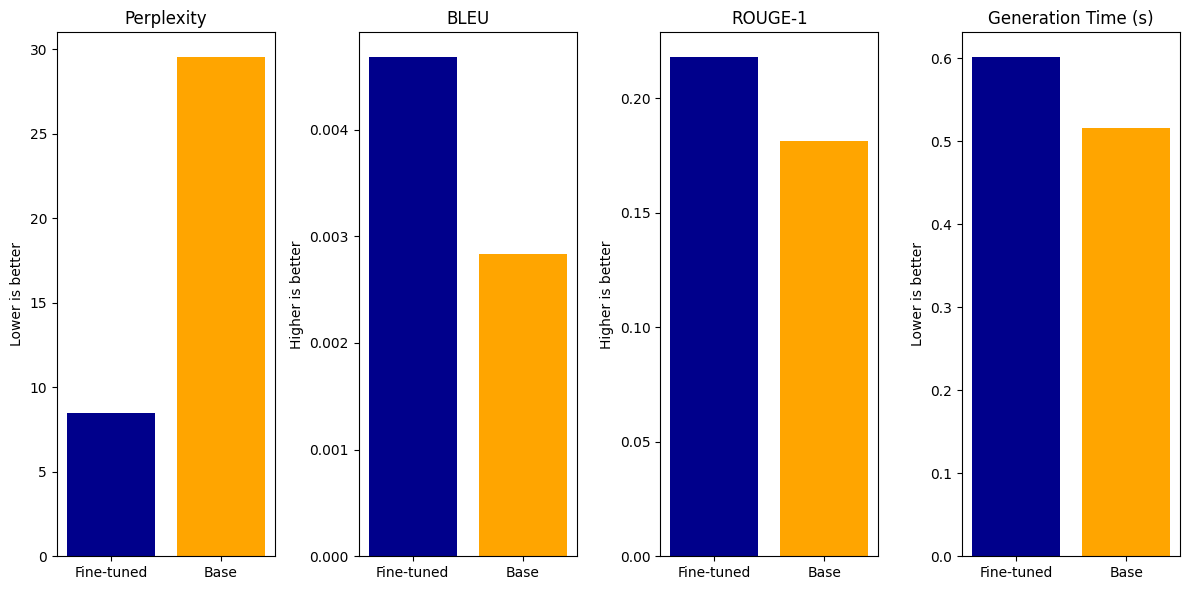

In [51]:
# Plot comparison chart
plt.figure(figsize=(12, 6))

# Create subplots for each metric
metrics_to_plot = ["Perplexity", "BLEU", "ROUGE-1", "Generation Time (s)"]
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, 4, i+1)
    plt.bar([0, 1], [metrics[metric][0], metrics[metric][1]],
            color=['darkblue', 'orange'])
    plt.title(metric)
    plt.xticks([0, 1], ['Fine-tuned', 'Base'])
    if metric == "Perplexity" or metric == "Generation Time (s)":
        plt.ylabel("Lower is better")
    else:
        plt.ylabel("Higher is better")

plt.tight_layout()

Looking at the evaluation metric scores, the fine-tuned model performs better in all 3 scores calculated against the base model. This indicates that the finetuned model has an overall better understanding of mental health terminology and concepts after finetuning. The higher perplexity of the base model indicates its response coherence and relevance is worse, and is likely to generate less tailored responses regarding mental health support. The trade-off however is that the finetuned model introduces heavy bias from the training data in its responses e.g. hallucinating and assuming a non-factual context upon user input.

The BLEU score for the finetuned model is marginally better, meaning it is more fluent in its responses in the mental health context - the base model may include more information not relevant to mental health topics. The ROUGE score is also marginally better for the finetuned model, meaning the base model is less likely to pick up on emotional cues or maintain therapeutic dialogue. That being said, the finetuned model tends to generate rigid/repetitive response patterns which is not helpful.

The response generation time for the base model is only slightly lower than that of the finetuned model. The former potentially has less domain-specific knowledge in its knowledge bank to curate its responses surround mental health. The finetuned model also took an additional 20 minutes to train on the domain-specific dataset for 3 epochs before being able to generate responses for the mental health objective.

### Future Enhancements

#### Improvements
Potential improvements for this finetuned model include expanding the training dataset - the mental health dataset only included 3.5k rows for the DistilGPT-2 model to work with, and it has a lot more power to train on a more expansive dataset covering various aspects of mental health support in-depth. Thus, it can learn on more nuanced mental health concepts to generate more appropriate and empathetic responses. This can also help reduce bias towards e.g. just relationship or work advice.


Another improvement can be made to context preservation, currently done by maintaining conversation_history. It needs to better remember previous exchanges when generating new responses. Response relevance checking can also be implemented to calculate a ROUGE score for semantic similarity within the generate_response function itself to detect any irrelevant responses and fallback to a default yet empathetic response in case the similarity isn't up to the mark (denoted by a threshold). There should also be a repetition penalty applied to the model's responses to avoid producing repeated responses and frustrating the already distressed user of this mental health chatbot - maybe a bank of alternative responses can be set to generate instead.

Knowledge distillation can be implemented for this chatbot so that the finetuned model can be trained to mimic teacher outputs of GPT-2 model, with the help of distillation loss.

### Scalability
Given there are unlimited computation resources available (smaller limits on GPU), this chatbot can be trained on millions more rows of mental health conversations and answers taken from various other therapy and counseling platforms. Rigourous training should be the main focus here as the mental health domain is particularly fragile where maintaining context about a user's emotional state and concerns across multiple turns is critical. Generating even the slightest irrelevant or inappropriate response to users when they are in distress will be unfavourable at the very least when deployed in the real-world.

In terms of the training infrastructure, we can execute distributed training on multiple GPUs to ramp up training load and rates to handle large datasets. We can also create efficient data loaders with caching mechanisms to enhance parallel data processing. This chatbot could also be deployed to the cloud, where a scalable API service can be created and logs of conversation can be stored in the backend in much larger quantities for context reference as the model learns on the go. Response Caching is also an option to generate common responses for common queries until the user provides more personalised context.

Clinical safety measures like crisis detection when someone indicates threat to their life can be implemented - information to lifelines or direct calls to emergency services can be made in these extreme cases. The whole system could also be moderated for performance and user feedbacks on the chatbot can help improve it even further upon deployment.